# Amazon food review dataset apply Decision Tree

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
1. As BOG and TFIDF has huge dimension try model in W2V avg and avg tfidf
2. Plot depth and CV error

# Import data and libraries
 

In [69]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [70]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [71]:
#take only 10000 + 10000 data
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(100)
_ , clean_data = train_test_split(sorted_data, test_size = 20000, stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

positive    16864
negative     3136
Name: Score, dtype: int64

In [72]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [73]:
i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    

In [74]:
clean_data['CleanedText']=final_string
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data['CleanedText'].sample(2)

144898    b'best can chili ever eaten hate bland food wa...
388298    b'recent gotten loos tea along friend mine enj...
Name: CleanedText, dtype: object

# Create AVG W2V

In [75]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  

#Sent_vectors ready for tsne   



In [76]:
from sklearn.preprocessing import StandardScaler
x=sent_vectors
y =clean_data['Score']
#Standarize the features
#below not working
#sc = StandardScaler(with_mean=False)
# this is sparse matrix so standarization is required differently
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)


#sc = StandardScaler()
#x = sc.fit_transform(x)
#print(x.get_shape())
print(type(x))
#print(x[[1]])


n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]

#y should be changed to binary

#from sklearn.preprocessing import label_binarize
#encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
#encoded_labels = np.ravel(encoded_column_vector) # Reshape array
#y=encoded_labels

y_test=y[0:n1]
y_train=y[n1:n+1]


X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

<class 'numpy.ndarray'>
size of X_train, X_test, y_train , y_test  (14000, 50) (6000, 50) (14000,) (6000,)


In [77]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

max_leaf_nodes=[]
max_depth=[1,2,3,4,5,6,7,8]

tuned_parameters=dict(max_depth=max_depth)

#Using GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)


print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimummaxdepth=model.best_estimator_.max_depth
print(type(X_train),type(y_train))


Best parameters 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [79]:
#build model with best parameter
model = DecisionTreeClassifier(max_depth=optimummaxdepth)
model.fit(X_train, y_train)
print('Model test score',model.score(X_test,y_test))

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


aa=pd.DataFrame({'type':['AVG W2V'],'depth':[optimummaxdepth],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})



Model test score 0.8385
Predicted  negative  positive    All
Actual                              
negative        384      1716   2100
positive        256     11644  11900
All             640     13360  14000


# Plot accuracy with tree depth

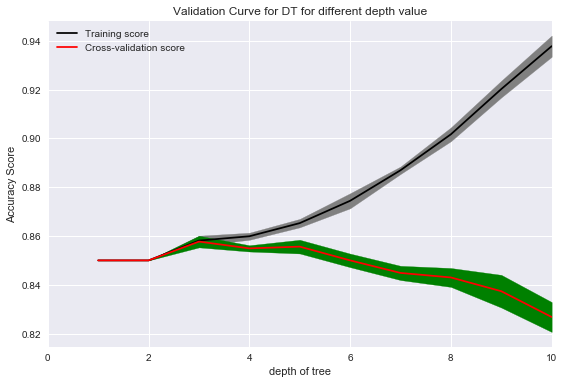

In [80]:
from sklearn.model_selection import validation_curve

max_depth=[1,2,3,4,5,6,7,8,9,10]
param_range=[1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(DecisionTreeClassifier(), X_train, y_train, param_name="max_depth",param_range=max_depth,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve for DT for different depth value")
plt.xlabel("depth of tree")
plt.ylabel("Accuracy Score")
plt.xlim(0,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()



# Create AVG Tfidf

X y train test  14000 6000 (14000,) (6000,)
Best parameters 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model test score 0.8355
Predicted  negative  positive    All
Actual                              
negative        290      1810   2100
positive        193     11707  11900
All             483     13517  14000


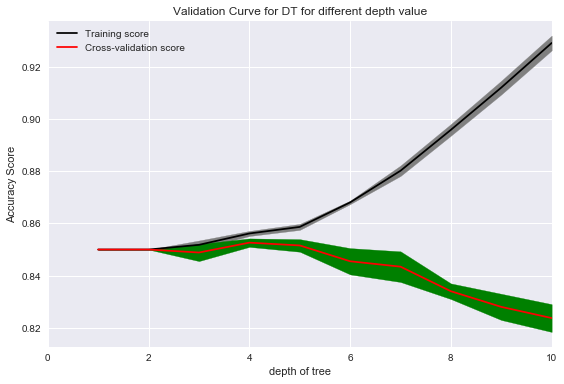

In [82]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
#tfidf_sent_vectors.


x=tfidf_sent_vectors
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=len(x)
n1=int(n*.3)
X_test = x[0:n1]
X_train= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('X y train test ',len(X_train),len(X_test),y_train.shape,y_test.shape)


# Grid search
max_depth=[1,2,3,4,5]
tuned_parameters=dict(max_depth=max_depth)
model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=5)
model.fit(X_train, y_train)


print('Best parameters \n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimummaxdepth=model.best_estimator_.max_depth



#build model with best parameter
model = DecisionTreeClassifier(max_depth=optimummaxdepth)
model.fit(X_train, y_train)
print('Model test score',model.score(X_test,y_test))

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['TFIDF W2V'],'depth':[optimummaxdepth],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest]})
aa=aa.append(bb)




from sklearn.model_selection import validation_curve

max_depth=[1,2,3,4,5,6,7,8,9,10]
param_range=[1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(DecisionTreeClassifier(), X_train, y_train, param_name="max_depth",param_range=max_depth,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve for DT for different depth value")
plt.xlabel("depth of tree")
plt.ylabel("Accuracy Score")
plt.xlim(0,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()




# Conclusion
This is bit difficult to work with more features in decision tree
Below is the score of different model

In [83]:
aa

,accuracy_test,accuracy_train,depth,fscore_test,fscore_train,type
0,0.8385,0.859143,3,0.908766,0.921932,AVG W2V
0,0.8355,0.856929,4,0.907972,0.921194,TFIDF W2V
